## Installing Libraries

In [ ]:
!pip install transformers 
!pip install datasets
!pip install torch 
!pip install sklearn 
!pip install streamlit 
!pip install gradio

### Loading Dataset 

In [ ]:
# 1. Load AG News dataset
dataset = load_dataset("ag_news")
train_data = dataset["train"]
test_data = dataset["test"]


## Training Model

### Using first approach but we get very poor results for it But I also Added it to get a better track of what actually happens

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Accuracy: 0.2561
F1-Score: 0.1443


<Figure size 800x600 with 0 Axes>

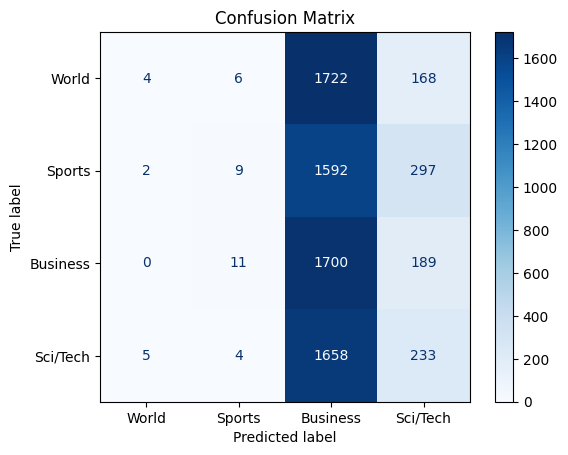

In [4]:
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import torch
import matplotlib.pyplot as plt


# 2. Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# 3. Tokenization with fixed length
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

tokenized_train = train_data.map(tokenize_function, batched=True)
tokenized_test = test_data.map(tokenize_function, batched=True)

# Set format for PyTorch
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# 4. Load model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

# 5. Define training arguments (wandb disabled)
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    report_to="none",  # disable wandb
    learning_rate=5e-5, # Add this line
    warmup_ratio=0.1, # Add this line (e.g., 10% of total steps)
    gradient_accumulation_steps=2,

)

# 6. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
)

# 7. Evaluate
predictions = trainer.predict(tokenized_test)
preds = np.argmax(predictions.predictions, axis=-1)

# Get true labels
true_labels = tokenized_test["label"]

# 8. Metrics
accuracy = accuracy_score(true_labels, preds)
f1 = f1_score(true_labels, preds, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")

# 9. Confusion matrix
labels = ["World", "Sports", "Business", "Sci/Tech"]
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot
plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


## Improved Solution Updated version
* updated the number of epochs, decreased the size of learning rate, added warmup ratio and other parameters

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted
1,0.231600,0.212338,0.935921,0.935906
2,0.176300,0.213332,0.943947,0.943945
3,0.119100,0.230517,0.945000,0.945022
4,0.074500,0.286154,0.944737,0.944794
5,0.031700,0.344374,0.943553,0.943513


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

Final Test Accuracy: 0.9436
Final Test F1-Score: 0.9435


<Figure size 800x600 with 0 Axes>

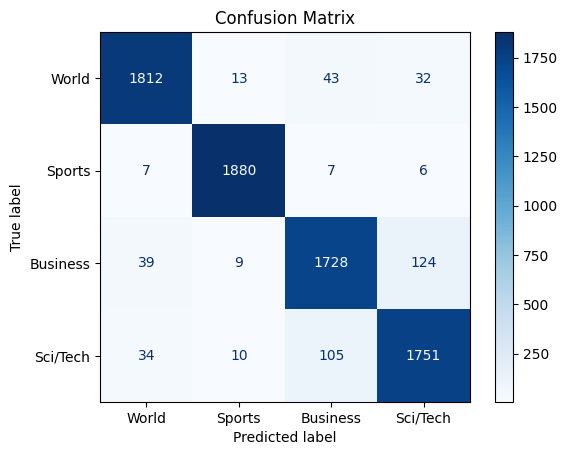

In [5]:
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import torch
import matplotlib.pyplot as plt

# 1. Load AG News dataset
dataset = load_dataset("ag_news")
train_data = dataset["train"]
test_data = dataset["test"]

# 2. Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# 3. Tokenization with fixed length
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128) # Keep 128 for now, but consider increasing

tokenized_train = train_data.map(tokenize_function, batched=True)
tokenized_test = test_data.map(tokenize_function, batched=True)

# Set format for PyTorch
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# 4. Load model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

# 5. Define training arguments (wandb disabled)
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,  # Increased epochs
    learning_rate=5e-5,  # Added learning rate
    warmup_ratio=0.1,    # Added warmup ratio
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    report_to="none",    # disable wandb
    # weight_decay=0.01, # Optional: Add L2 regularization if overfitting is observed
    # gradient_accumulation_steps=2, # Optional: If simulating larger batch size due to memory constraints
)

# 6. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    # compute_metrics=compute_metrics, # You can add this if you want metrics calculated during evaluation
)

# Define compute_metrics function for evaluation during training (optional but good practice)
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=-1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1_weighted": f1_score(p.label_ids, preds, average="weighted"),
    }

# Assign compute_metrics to the Trainer
trainer.compute_metrics = compute_metrics

# 7. Train the model
trainer.train()

# 8. Evaluate on the test set after training
predictions = trainer.predict(tokenized_test)
preds = np.argmax(predictions.predictions, axis=-1)

# Get true labels
true_labels = tokenized_test["label"]

# 9. Metrics
accuracy = accuracy_score(true_labels, preds)
f1 = f1_score(true_labels, preds, average="weighted")

print(f"Final Test Accuracy: {accuracy:.4f}")
print(f"Final Test F1-Score: {f1:.4f}")

# 10. Confusion matrix
labels = ["World", "Sports", "Business", "Sci/Tech"]
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot
plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

## Deploying the model

In [8]:
from transformers import BertForSequenceClassification, BertTokenizer
from huggingface_hub import HfApi
import shutil
import os

# Paths
checkpoint_path = "Here I put my model path of original Directory"
repo_name = "ShahzaibAli-1/News_Classifier-bert-base-uncased"

# 1. First load the original tokenizer
original_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# 2. Save tokenizer files to your checkpoint directory
original_tokenizer.save_pretrained(checkpoint_path)

# 3. Now load your model and tokenizer
model = BertForSequenceClassification.from_pretrained(checkpoint_path)
tokenizer = BertTokenizer.from_pretrained(checkpoint_path)  # This will now work

# 4. Push to Hub
model.push_to_hub(repo_name)
tokenizer.push_to_hub(repo_name)

print(f"Model uploaded to: https://huggingface.co/{repo_name}")

Uploading...:   0%|          | 0.00/438M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

Model uploaded to: https://huggingface.co/ShahzaibAli-1/News_Classifier-bert-base-uncased


## Using Gradio to test out our deployed Model you can input the news of your type 

In [13]:
import gradio as gr
from transformers import pipeline

# Load model
classifier = pipeline("text-classification", model="ShahzaibAli-1/News_Classifier-bert-base-uncased")

# Define label mapping (must match your training labels)
label_map = {
    0: "World",
    1: "Sports", 
    2: "Business",
    3: "Sci/Tech"
}

def predict(text):
    result = classifier(text)[0]
    # Extract numerical label (e.g., "LABEL_1" -> 1)
    label_num = int(result['label'].split("_")[-1])
    # Get corresponding text label
    label_text = label_map[label_num]
    return f"{label_text} (confidence: {result['score']:.2%})"

# Create interface
iface = gr.Interface(
    fn=predict,
    inputs=gr.Textbox(lines=2, placeholder="Enter news text here..."),
    outputs="text",
    title="AG News Classifier",
    description="Classify news articles into World, Sports, Business, or Sci/Tech categories"
)

iface.launch()

Device set to use cuda:0


* Running on local URL:  http://127.0.0.1:7863
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://c02e7985bb9908cf76.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
